     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.1 MB/s eta 0:00:00
Mounted at /content/drive
Checking directory: /content/drive/My Drive/FYP/mimic_perform_non_af_wfdb
Bad signal detected for record: mimic_perform_non_af_012, skipping. Error: 
------------

/usr/local/lib/python3.11/dist-packages/heartpy/analysis.py:677: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  interp = UnivariateSpline(x, rrlist, k=3)


User appended  mimic_perform_non_af_004
Total length of normalized PPG signal: 150001
Total scalograms saved for user mimic_perform_non_af_004: 60
User appended  mimic_perform_non_af_013
Total length of normalized PPG signal: 150001
Total scalograms saved for user mimic_perform_non_af_013: 60
User appended  mimic_perform_non_af_007
Total length of normalized PPG signal: 150001
Total scalograms saved for user mimic_perform_non_af_007: 60
User appended  mimic_perform_non_af_015
Total length of normalized PPG signal: 150001
Total scalograms saved for user mimic_perform_non_af_015: 60
User appended  mimic_perform_non_af_010
Total length of normalized PPG signal: 150001
Total scalograms saved for user mimic_perform_non_af_010: 60
User appended  mimic_perform_non_af_005
Total length of normalized PPG signal: 150001
Total scalograms saved for user mimic_perform_non_af_005: 60
User appended  mimic_perform_non_af_016
Total length of normalized PPG signal: 150001
Total scalograms saved for user 

KeyboardInterrupt: 

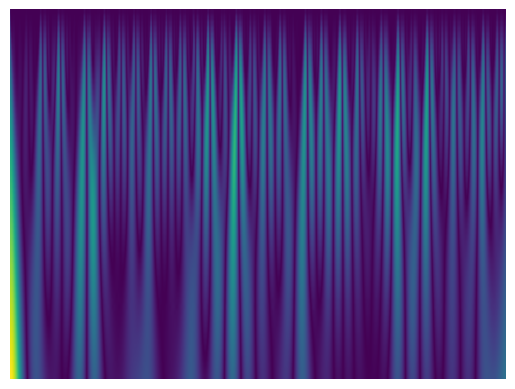

In [1]:

!pip install wfdb
!pip install heartpy
!pip install PyWavelets
import pathlib
import os
import wfdb
import heartpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pywt as PyWavelets
# VARIABLE DECLARATION
sf = 125
# Window size that we want in seconds (20, 30,...)
window_size = 20
# Total duration of the PPG sample, in this case, 20min
ppg_duration = 1200

# Getting PPG files (hea and dat) and declaring other paths
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
base_path = pathlib.Path("/content/drive/My Drive/FYP")  # Update if needed

af_subjects_dir = base_path / "mimic_perform_af_wfdb"
non_af_subjects_dir = base_path / "mimic_perform_non_af_wfdb" #changed the directory here
af_ppm_dir = base_path / "Scalogram"
non_af_ppm_dir = base_path / "Scalogram"

# Creating a list of all dat files
def normalise(signal):
    a, b = -1, 1
    c = b - a
    aux = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    return c * aux + a
#NAF FILES
dat_records = []
print(f"Checking directory: {non_af_subjects_dir}") #Added a print to monitor this
for file in os.listdir(non_af_subjects_dir):
    if file.endswith(".dat"):
        record = file.replace(".dat", "")
        dat_records.append(record)

# Extract list of PPG peaks for each user
# stored as key:peaks,signal
users_ppg = {}
for record in dat_records:
    # Changed line: the path needs to be a string
    try:
        sig, fields = wfdb.rdsamp(str(non_af_subjects_dir)+'/'+record)
        ppg_signal = sig[:, 0]
        wd, m = hp.process(ppg_signal, sf)
        ppg_info = []
        ppg_info.append(wd['peaklist'])
        ppg_info.append(ppg_signal)
        users_ppg[record] = ppg_info
    except hp.exceptions.BadSignalWarning as e:
        print(f"Bad signal detected for record: {record}, skipping. Error: {e}")
        continue

obtained_users = []
init_window = 0
total_image=0
# Process each user
for key in users_ppg.keys():
    if str(key) in obtained_users:
        continue
    else:
        obtained_users.append(str(key))
        print('User appended ', key)

    init_window = 0
    peaks = users_ppg.get(key)[0]
    ppg = users_ppg.get(key)[1]
    window_samp = int((window_size * len(ppg)) / ppg_duration)

    # Normalize the full PPG signal
    norm_ppg = normalise(ppg)
    print(f"Total length of normalized PPG signal: {len(norm_ppg)}")

    total_image = 0
    i = 0

    # Process the PPG signal in 20-second windows
    while init_window < len(norm_ppg):
        # Ensure we don't exceed the signal length
        if init_window + window_samp > len(norm_ppg):
            break

        # Extract the 20-second segment
        segment = norm_ppg[init_window:init_window + window_samp]

        # Perform CWT on the segment
        scales = np.arange(1, 65)
        coeffs, freqs = PyWavelets.cwt(segment, scales=scales, wavelet='gaus1')
        scalogram = np.abs(coeffs)

        # Save the scalogram
        plt.imshow(scalogram, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.savefig(f"{non_af_ppm_dir}/Non_AF_{key}_{i}_cwt.png", bbox_inches='tight', pad_inches=0)
        plt.close('all')
        total_image += 1
        i += 1

        # Move to the next window
        init_window += window_samp

    print(f"Total scalograms saved for user {key}: {total_image}")
#AF FILES
dat_records = []
print(f"Checking directory: {af_subjects_dir}")#Added a print to monitor this
for file in os.listdir(af_subjects_dir):
    if file.endswith(".dat"):
        record = file.replace(".dat", "")
        dat_records.append(record)

# Extract list of PPG peaks for each user
# stored as key:peaks,signal
users_ppg = {}
for record in dat_records:
    # Changed line: the path needs to be a string
    try:
        sig, fields = wfdb.rdsamp(str(af_subjects_dir)+'/'+record)
        ppg_signal = sig[:, 0]
        wd, m = hp.process(ppg_signal, sf)
        ppg_info = []
        ppg_info.append(wd['peaklist'])
        ppg_info.append(ppg_signal)
        users_ppg[record] = ppg_info
    except hp.exceptions.BadSignalWarning as e:
         print(f"Bad signal detected for record: {record}, skipping. Error: {e}")
         continue


obtained_users = []
init_window = 0
total_image=0
# Process each user
for key in users_ppg.keys():
    if str(key) in obtained_users:
        continue
    else:
        obtained_users.append(str(key))
        print('User appended ', key)

    init_window = 0
    peaks = users_ppg.get(key)[0]
    ppg = users_ppg.get(key)[1]
    window_samp = int((window_size * len(ppg)) / ppg_duration)

    # Normalize the full PPG signal
    norm_ppg = normalise(ppg)
    print(f"Total length of normalized PPG signal: {len(norm_ppg)}")

    total_image = 0
    i = 0

    # Process the PPG signal in 20-second windows
    while init_window < len(norm_ppg):
        # Ensure we don't exceed the signal length
        if init_window + window_samp > len(norm_ppg):
            break

        # Extract the 20-second segment
        segment = norm_ppg[init_window:init_window + window_samp]

        # Perform CWT on the segment
        scales = np.arange(1, 65)
        coeffs, freqs =PyWavelets.cwt(segment, scales=scales, wavelet='gaus1')
        scalogram = np.abs(coeffs)

        # Save the scalogram
        plt.imshow(scalogram, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.savefig(f"{af_ppm_dir}/AF_{key}_{i}_cwt.png", bbox_inches='tight', pad_inches=0)
        plt.close('all')
        total_image += 1
        i += 1

        # Move to the next window
        init_window += window_samp

    print(f"Total scalograms saved for user {key}: {total_image}")

In [4]:
# === 1. Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === 2. Install Required Packages ===
!pip install wfdb heartpy PyWavelets

# === 3. Import Libraries ===
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import heartpy as hp
import pywt
import pathlib

# === 4. Helper Functions ===
def normalise(signal):
    a, b = -1, 1
    c = b - a
    aux = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    norm_signal = c * aux + a
    return norm_signal

def mean_peak_dist(peaks):
    dist = []
    for i in range(len(peaks)):
        if peaks[i] == peaks[-1]:
            break
        d = peaks[i + 1] - peaks[i]
        if i == 0:
            dist.append(d)
            continue
        if d > np.mean(dist) + np.std(dist) * 2:
            continue
        else:
            dist.append(d)
    return np.mean(dist)

# === 5. Set Paths and Parameters ===
sf = 125
window_size = 20       # seconds
ppg_duration = 1200    # total signal duration assumed to be 20 minutes

base_path = pathlib.Path("/content/drive/My Drive/FYP")  # Update if needed

af_subjects_dir = base_path / "mimic_perform_af_wfdb"
non_af_subjects_dir = base_path / "mimic_perform_non_af_wfdb"
af_ppm_dir = base_path / "Scalogram" / "AF"
non_af_ppm_dir = base_path / "Scalogram" / "Non_AF"

# Create directories if they don't exist
os.makedirs(af_ppm_dir, exist_ok=True)
os.makedirs(non_af_ppm_dir, exist_ok=True)

# === 6. Process Non-AF Records ===
non_af_records = [file.replace(".dat", "") for file in os.listdir(non_af_subjects_dir) if file.endswith(".dat")]
users_ppg = {}

for record in non_af_records:
    try:
        sig, fields = wfdb.rdsamp(str(non_af_subjects_dir / record))
        ppg_signal = sig[:, 0]
        wd, m = hp.process(ppg_signal, sf)
        users_ppg[record] = [wd['peaklist'], ppg_signal]
    except Exception as e:
        print(f"Error processing non-AF record {record}: {e}")
        continue

for key, (peaks, ppg) in users_ppg.items():
    print('Processing Non-AF User:', key)
    window_samp = int((window_size * len(ppg)) / ppg_duration)
    norm_ppg = normalise(ppg)
    init_window = 0
    i = 0

    while init_window + window_samp <= len(norm_ppg):
        segment = norm_ppg[init_window:init_window + window_samp]
        scales = np.arange(1, 65)
        coeffs, freqs = pywt.cwt(segment, scales=scales, wavelet='gaus1')
        scalogram = np.abs(coeffs)

        plt.figure(figsize=(4, 4))
        plt.imshow(scalogram, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.savefig(str(non_af_ppm_dir / f"Non_AF_{key}_{i}_cwt.png"), bbox_inches='tight', pad_inches=0, dpi=100)
        plt.close()
        i += 1
        init_window += window_samp

# === 7. Process AF Records ===
af_records = [file.replace(".dat", "") for file in os.listdir(af_subjects_dir) if file.endswith(".dat")]
users_ppg = {}

for record in af_records:
    try:
        sig, fields = wfdb.rdsamp(str(af_subjects_dir / record))
        ppg_signal = sig[:, 0]
        wd, m = hp.process(ppg_signal, sf)
        users_ppg[record] = [wd['peaklist'], ppg_signal]
    except Exception as e:
        print(f"Error processing AF record {record}: {e}")
        continue

for key, (peaks, ppg) in users_ppg.items():
    print('Processing AF User:', key)
    window_samp = int((window_size * len(ppg)) / ppg_duration)
    norm_ppg = normalise(ppg)
    init_window = 0
    i = 0

    while init_window + window_samp <= len(norm_ppg):
        segment = norm_ppg[init_window:init_window + window_samp]
        scales = np.arange(1, 65)
        coeffs, freqs = pywt.cwt(segment, scales=scales, wavelet='gaus1')
        scalogram = np.abs(coeffs)

        plt.figure(figsize=(4, 4))
        plt.imshow(scalogram, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.savefig(str(af_ppm_dir / f"AF_{key}_{i}_cwt.png"), bbox_inches='tight', pad_inches=0, dpi=100)
        plt.close()
        i += 1
        init_window += window_samp

print("Processing complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error processing non-AF record mimic_perform_non_af_012: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------

Error processing non-AF record mimic_perform_non_af_014: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling fi